Christian Hansen  
02/03/2017  
Project Luther  
Scraping of big dataset

In [1]:
from urllib2 import urlopen
from bs4 import BeautifulSoup
import requests
import pandas as pd
import unicodedata
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
//anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


## Functions to scrape imdb's highest voted movies for their features

In [ ]:
def get_movie_title_urls(p_num):
    movie_title =[]
    movie_url = []
    url = 'http://www.imdb.com/search/title?sort=num_votes,desc&start=1&title_type=feature&year=1950,2012&page={}&ref_=adv_prv'
    url = url.format(str(p_num))
    print(url)
    r = requests.get(url) # where url is the above url    
    bs = BeautifulSoup(r.text,'lxml')
    for i in range(50):

        try:
            movie_url.append(bs.findAll(class_='lister-list')[0]
                             .findAll('div',{"class":"lister-item-content"})[i].find('a')['href'])

            movie_title.append(bs.findAll(class_='lister-list')[0]
                               .findAll('div',{"class":"lister-item-content"})[i].find('a').text)
        except:
            movie_url.append(np.nan)
            movie_title.append(np.nan)
        url_total = ["http://www.imdb.com" + str(url_end) for url_end in movie_url]
    return(movie_title,url_total)

In [ ]:
def get_all(url_total,title_total):
    
    budget_list = []
    gross_list= []
    runtime_list = []
    imdb_list = []
    number_list = []
    meta_list = []
    year_list = []
    
    for i in range(len(url_total)):
        print(i)
        page = requests.get(url_total[i]).text
        bs_temp = BeautifulSoup(page,'lxml')
        try:
            budget = (bs_temp.find(text = 'Budget:').next).strip().replace('$','').replace(',','')
            gross = bs_temp.find(text = 'Gross:').next.strip().replace('$','').replace(',','')
            runtime =bs_temp.find(text = 'Runtime:').findNext("").text.split()[0]
            imdb_scores =bs_temp.find('span',attrs={'itemprop':'ratingValue'}).text
            number_votes = bs_temp.find('span',attrs={'itemprop':'ratingCount'}).text
            meta_score = bs_temp.find(class_ = 'titleReviewBarItem').find('span').text
            year = bs_temp.find(id= 'titleYear').text.strip('()')
            
            meta_list.append(meta_score)
            number_list.append(number_votes)
            imdb_list.append(imdb_scores)
            budget_list.append(budget)
            gross_list.append(gross)
            runtime_list.append(runtime)
            year_list.append(year)
        except:
            budget_list.append(np.nan)
            meta_list.append(np.nan)
            number_list.append(np.nan)
            imdb_list.append(np.nan)
            gross_list.append(np.nan)
            runtime_list.append(np.nan)
            year_list.append(np.nan)
            
    df = pd.DataFrame([title_total,meta_list,number_list,imdb_list,budget_list,gross_list,runtime_list,year_list]).T
    df.columns = ['movie_title','meta_score' ,'number_of_votes','imdb_score','budget','gross','runtime','year']
    return(df)

## This loops through as many pages as I'd like and adds this to a title and url list

In [ ]:
total_titles = []
total_urls = []
for i in range(1,100):
    titles, urls = get_movie_title_urls(i)
    total_titles += titles
    total_urls += urls

# I pass the title and url lists into the get_all function to make a dataframe of all movies given the url exists

In [ ]:
dead = get_all(total_urls,total_titles)

In [ ]:
dead.dropna().shape

## Save or load Dataframes

In [ ]:
"""import pickle
pickle.dump(dead, open('dead_df_.p', 'wb'))
"""

In [38]:
import pickle
file = open("dead_df_.p",'rb')
loaded_df = pickle.load(file)
file.close()
loaded_df.head()

,movie_title,meta_score,number_of_votes,imdb_score,budget,gross,runtime,year
0,The Shawshank Redemption,80,"1,765,612",9.3,25000000,28341469,142,1994
1,The Dark Knight,82,"1,748,063",9.0,185000000,533316061,152,2008
2,Inception,74,"1,539,791",8.8,160000000,292568851,148,2010
3,Fight Club,66,"1,411,440",8.8,63000000,37023395,139,1999
4,Pulp Fiction,94,"1,382,534",8.9,8000000,107930000,154,1994


In [6]:
clean_df = clean_df.dropna().copy()
clean_df.shape

(3378, 8)

## Clean up the data and dop nan values

In [7]:
def clean_funct(score):
    if str(score).isdigit():
        return(score)
    else:
        return(np.nan)

In [8]:
def clean_and_int(val):
    if type(val) == unicode:
        if len(val.split(' ')) == 2 and val.isdigit() :
            return(int(val.split(' ')[1]))

        elif len(val.split(' ')) ==1 and val.isdigit():
            return(int(val.split(' ')[0]))
        else:
            return(np.nan)
    elif type(val) == float:
        return(val)
    else:
        print 'not unicode'
        print type(val), val
        return(np.nan)

In [9]:
clean_df['meta_score'] = clean_df['meta_score'].apply(clean_and_int)
clean_df['number_of_votes'] = clean_df['number_of_votes'].apply(lambda x: float(str(x).replace(',','')))
clean_df['imdb_votes'] = clean_df['imdb_score'].apply(lambda x: float(x))
clean_df['budget'] = clean_df['budget'].apply(clean_and_int)
clean_df['Adjusted_gross'] = clean_df['gross'].apply(lambda x: float(x))

In [10]:
clean_df.shape

(3378, 10)

In [ ]:
## draw smaller sample from big set 500 or less to compare the two datasets
## look at how budget influences indi movies versus bigger more popular movies

## Use conversion list from www.boxofficemojo.com to get estimated number of tickets and adjusted gross price

In [11]:
clean_df['year']= clean_df['year'].apply(lambda x: int(x))

In [12]:
conversion = pd.read_csv('conversion.txt',delimiter='\t')
conversion.columns = ['year','Avg. Price']
conversion.ix[0,'Avg. Price'] = "8.65"
conversion['Avg. Price'] = conversion['Avg. Price'].apply(lambda x: float(x.strip('$'))) 
conversion['rate'] = conversion['Avg. Price']/conversion.ix[1,'Avg. Price'] 
conversion.head()
#revenue/rate

,year,Avg. Price,rate
0,2017,8.65,1.000000
1,2016,8.65,1.000000
2,2015,8.43,0.974566
3,2014,8.17,0.944509
4,2013,8.13,0.939884


In [13]:
clean_df.head()

,movie_title,meta_score,number_of_votes,imdb_score,budget,gross,runtime,year,imdb_votes,Adjusted_gross
0,The Shawshank Redemption,80.0,1765612.0,9.3,25000000.0,28341469,142,1994,9.3,28341469.0
1,The Dark Knight,82.0,1748063.0,9.0,185000000.0,533316061,152,2008,9.0,533316061.0
2,Inception,74.0,1539791.0,8.8,160000000.0,292568851,148,2010,8.8,292568851.0
3,Fight Club,66.0,1411440.0,8.8,63000000.0,37023395,139,1999,8.8,37023395.0
4,Pulp Fiction,94.0,1382534.0,8.9,8000000.0,107930000,154,1994,8.9,107930000.0


In [14]:
clean_df = pd.merge(clean_df,conversion,how='left', on='year')
clean_df['est_tickets'] = clean_df['Adjusted_gross']/clean_df['Avg. Price']
clean_df['Adjusted_gross'] = clean_df['est_tickets']*clean_df['Avg. Price']
#clean_df['Adjusted_gross'] = clean_df['Adjusted_gross']/clean_df['rate_x']
clean_df['runtime'] = clean_df['runtime'].apply(lambda x: int(x))
#clean_df['genre_list'] =clean_df['genre'].apply(lambda x: len(x))
#clean_df['budget'] = budget_list
clean_df['meta_score'] = clean_df['meta_score'].apply(lambda x: float(x)/10)
clean_df['imdb_score'] = clean_df['imdb_score'].apply(lambda x: float(x))

In [15]:
clean_df.dropna(inplace = True)
clean_df.head()

,movie_title,meta_score,number_of_votes,imdb_score,budget,gross,runtime,year,imdb_votes,Adjusted_gross,Avg. Price,rate,est_tickets
0,The Shawshank Redemption,8.0,1765612.0,9.3,25000000.0,28341469,142,1994,9.3,28341469.0,4.18,0.483237,6.780256e+06
1,The Dark Knight,8.2,1748063.0,9.0,185000000.0,533316061,152,2008,9.0,533316061.0,7.18,0.830058,7.427800e+07
2,Inception,7.4,1539791.0,8.8,160000000.0,292568851,148,2010,8.8,292568851.0,7.89,0.912139,3.708097e+07
3,Fight Club,6.6,1411440.0,8.8,63000000.0,37023395,139,1999,8.8,37023395.0,5.08,0.587283,7.288070e+06
4,Pulp Fiction,9.4,1382534.0,8.9,8000000.0,107930000,154,1994,8.9,107930000.0,4.18,0.483237,2.582057e+07


## Exploring the data

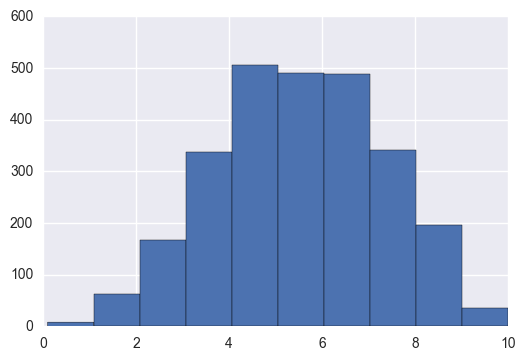

In [19]:
clean_df['meta_score'].hist()

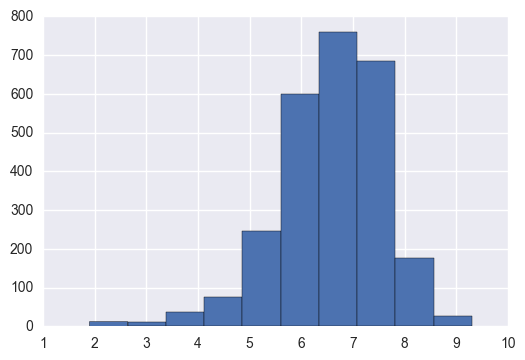

In [18]:
clean_df['imdb_score'].hist()

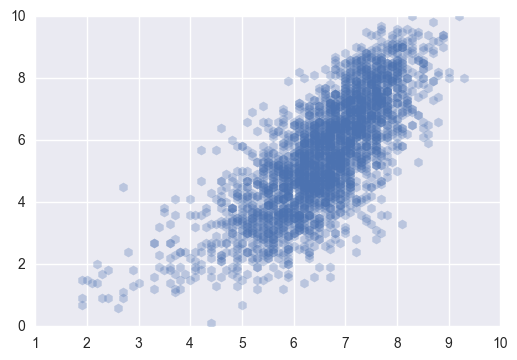

In [20]:
plt.plot(clean_df['imdb_score'],clean_df['meta_score'],'h',alpha = 0.3)

Looks like a mostly linear trend for the two scores. This would indicate a high correlation. I shouldn't use this as a feature.

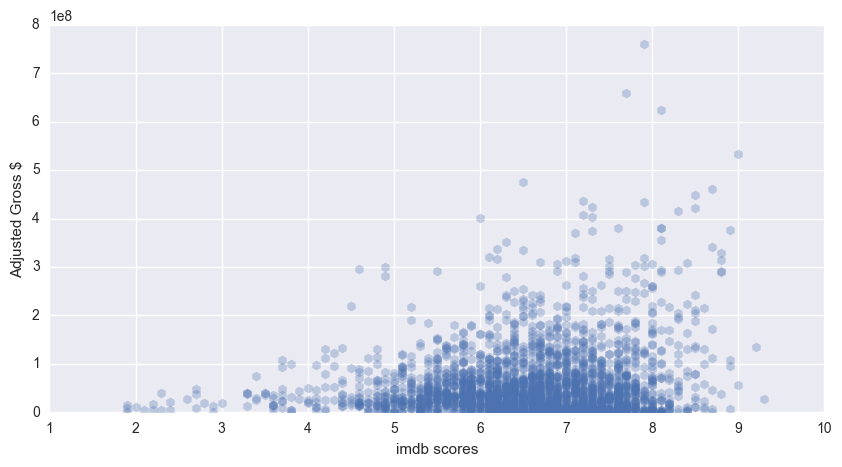

In [21]:
plt.figure(figsize = (10,5))
plt.plot(clean_df['imdb_score'],clean_df['Adjusted_gross'],'h',alpha = 0.3)
plt.xlabel('imdb scores')
plt.ylabel('Adjusted Gross $')

(1972, 2012)

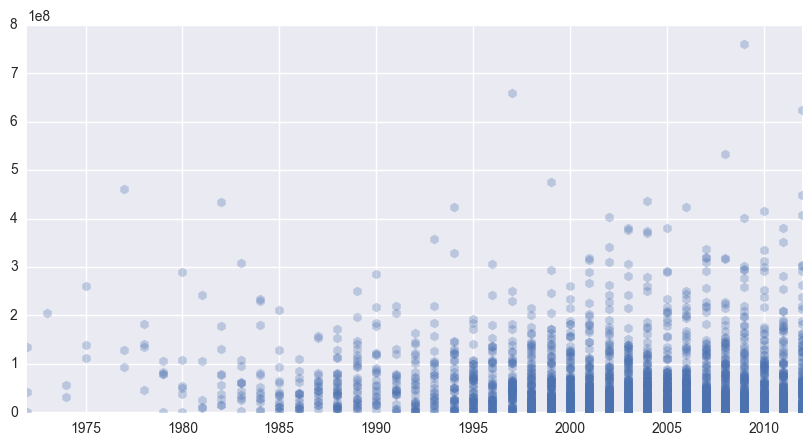

In [22]:
plt.figure(figsize = (10,5))
sort_df = clean_df.sort_values('year')
plt.plot(sort_df['year'],(sort_df['Adjusted_gross']),'h',alpha = 0.3)
plt.xlim([1972,2012])

## Looking at correlations of features values

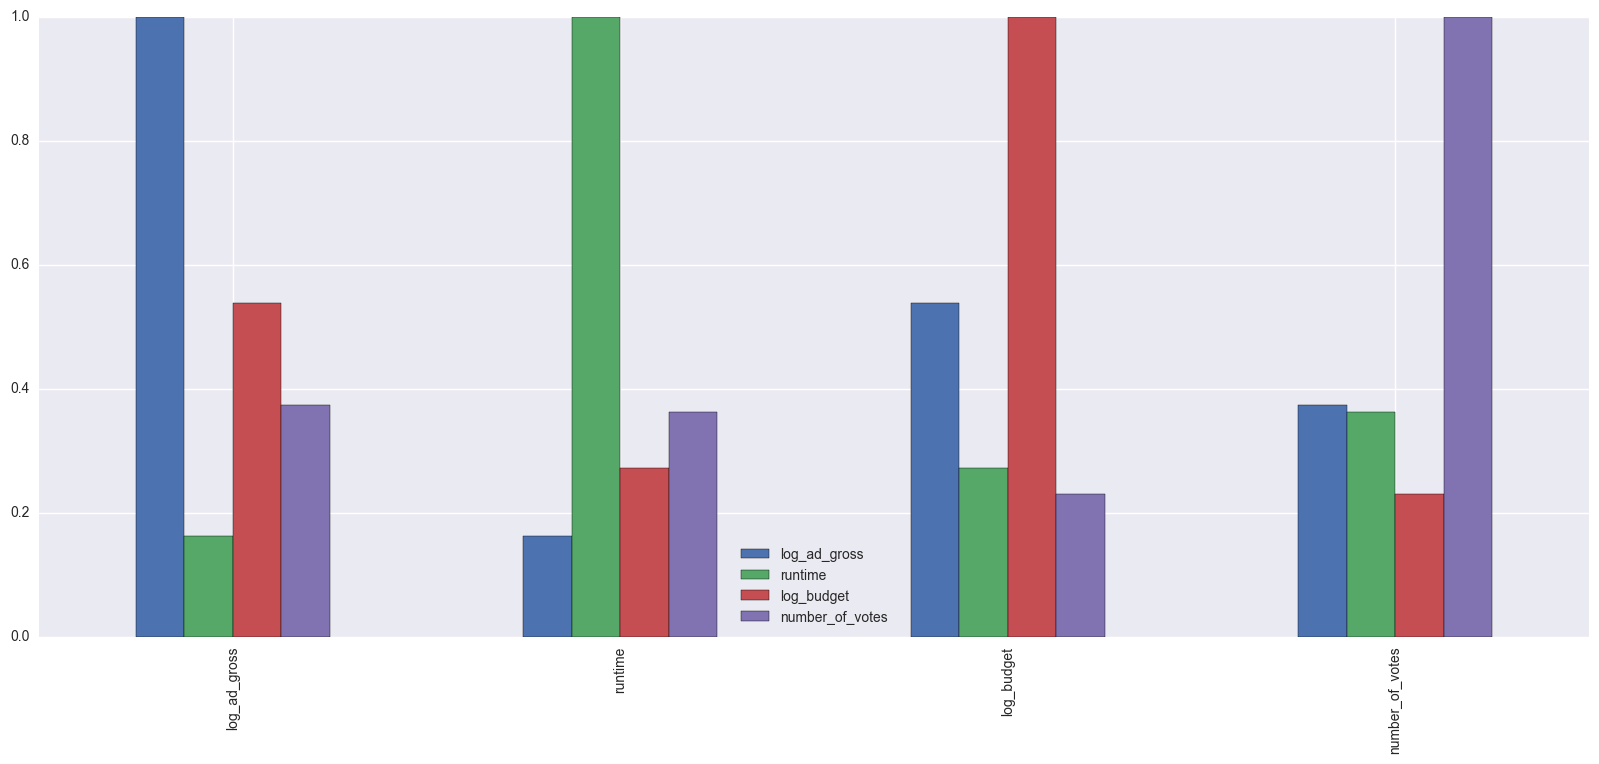

In [36]:
X.corr().plot(kind = 'bar',figsize=(20, 8))

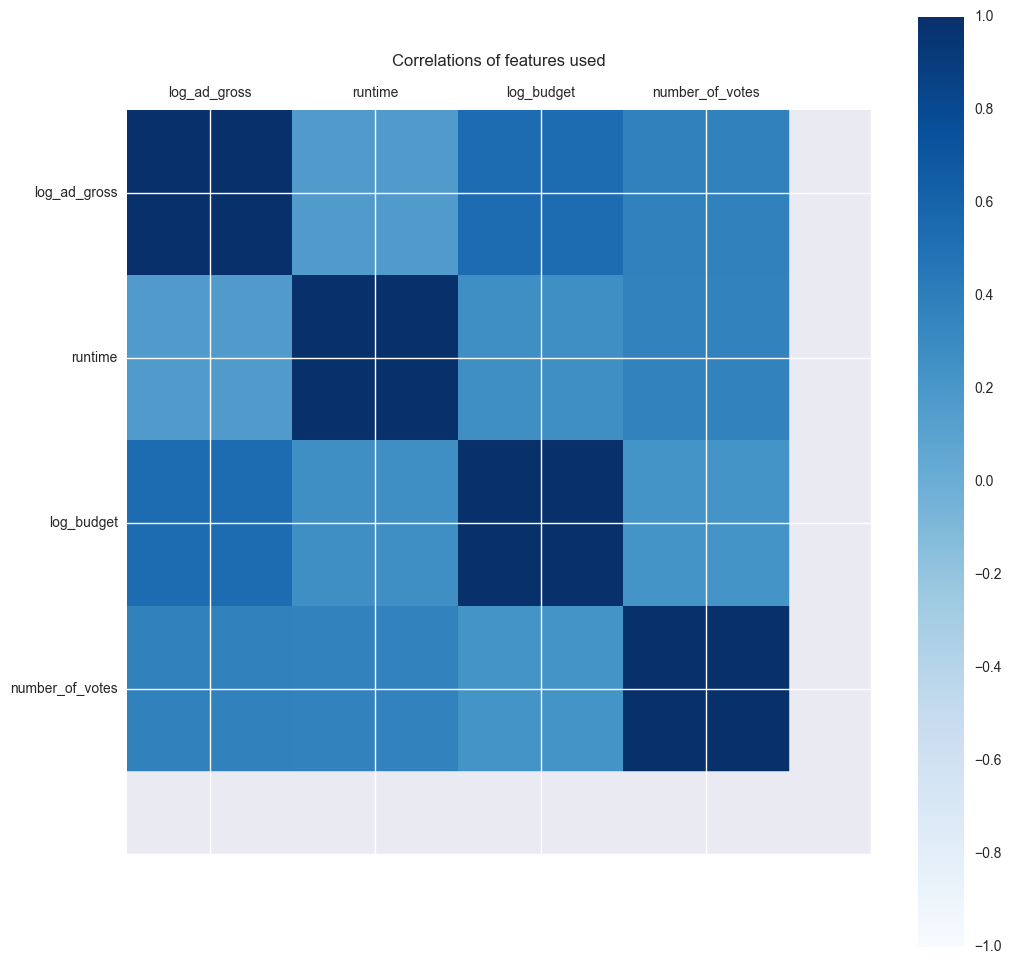

In [37]:
correlations = X.corr()
# plot correlation matrix
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1,cmap='Blues')
fig.colorbar(cax)
ticks = np.arange(0,5,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(features)
ax.set_yticklabels(features)
plt.title('Correlations of features used')
plt.show()


More movies made after the 1980's

## Running Regression for various models

In [23]:
import sklearn
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

## Taking a look at the regression using a select few features
clean_df['log_budget'] = np.log10(clean_df['budget'])
clean_df['log_ad_gross'] = np.log10(clean_df['Adjusted_gross'])
clean_df['sqrt_num_votes'] = (clean_df['number_of_votes'].apply(lambda x: int(x)**(1.0/2)))
features =['log_ad_gross','runtime','log_budget','number_of_votes']
X = clean_df[features]
#X['meta_score'] = X['meta_score'].apply(lambda x: float(x))
X['number_of_votes'] = X['number_of_votes'].apply(lambda x: float(x))
y = clean_df['imdb_votes']
X = X[y.notnull()]
y = y[y.notnull()]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=20)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


('rsquared: ', 0.41322250832997309)
('mse: ', 0.58772480575914288)


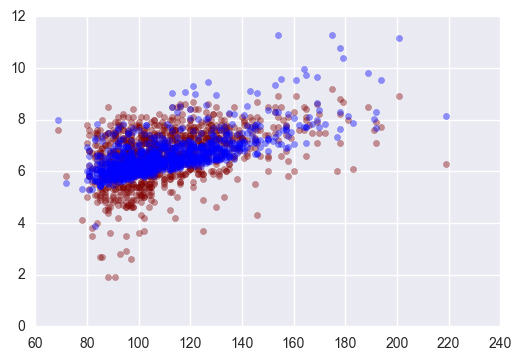

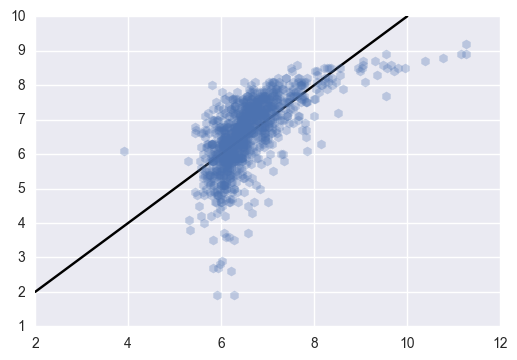

In [26]:
lr = LinearRegression()
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
from sklearn.metrics import mean_squared_error, r2_score
plt.scatter([X_test.iloc[:,1]],y_test,color='maroon',alpha = 0.4)
plt.scatter([X_test.iloc[:,1]],predictions,color='blue',alpha =0.4)
print('rsquared: ' ,r2_score(y_test,predictions))
print('mse: ', mean_squared_error(y_test,predictions))
plt.show()
plt.plot(np.linspace(2,10,1000),np.linspace(2,10,1000),'k')
plt.plot(predictions,y_test,'h',alpha = 0.3)

## Random Forest

('rsquared: ', 0.53335428106161653)
('mse: ', 0.46739908809526409)


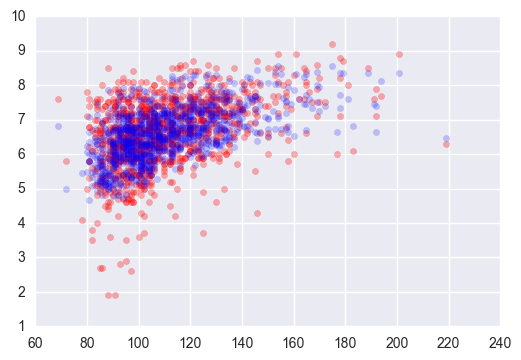

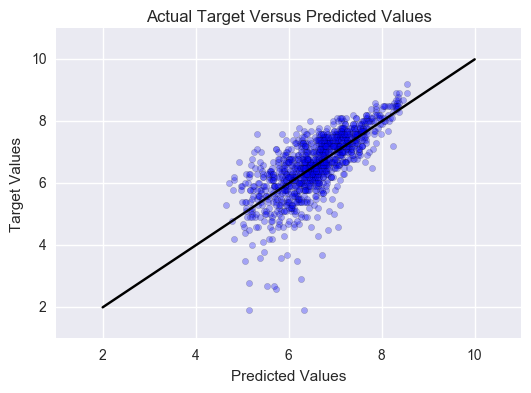

In [27]:
from sklearn.ensemble import RandomForestRegressor
import sklearn
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error


## Taking a look at the regression using a select few features

rfmodel2=RandomForestRegressor(n_estimators=1000,min_samples_split=12,min_samples_leaf=5,max_features="sqrt",n_jobs=-1)
rfmodel2.fit(X_train,y_train)
rf2_test_pred = rfmodel2.predict(X_test)

print('rsquared: ' ,r2_score(y_test,rf2_test_pred))
print('mse: ', mean_squared_error(y_test,rf2_test_pred))

plt.scatter([X_test.iloc[:,1]],y_test,color='red',alpha = 0.3)
plt.scatter([X_test.iloc[:,1]],rf2_test_pred,color='blue',alpha = .2)
plt.show()

plt.scatter(rf2_test_pred,y_test,alpha=.3)
plt.plot(np.linspace(2,10,1000),np.linspace(2,10,1000),'k')
plt.title('Actual Target Versus Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Target Values')
#plt.plot(np.linspace(0,600000,1000),np.linspace(0,600000,1000))
plt.show()

## Gradient Boosting

('Mean Squared Error:', 0.59779656382763791)
('r-squared score: ', 0.20968050912867087)


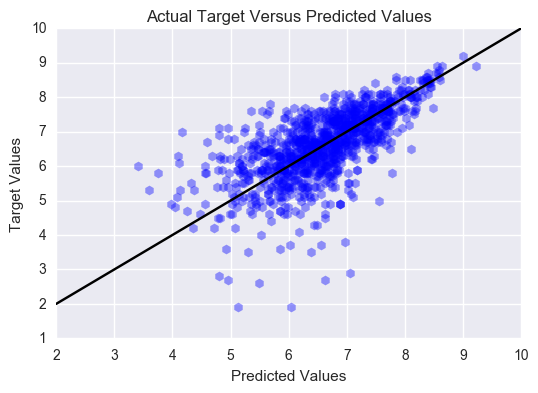

In [28]:
from sklearn.ensemble import GradientBoostingRegressor
gbmodel1 = GradientBoostingRegressor(subsample= 0.2,n_estimators=1000, learning_rate=0.02,max_depth=15,min_samples_split= 5)
gbmodel1.fit(X_train,y_train)
gb1_test_pred = gbmodel1.predict(X_test)
print('Mean Squared Error:',mean_squared_error(gb1_test_pred,y_test))
print('r-squared score: ',r2_score(gb1_test_pred,y_test))

plt.plot(gb1_test_pred,y_test,'hb',alpha=.4)
plt.plot(np.linspace(2,10,100),np.linspace(2,10,100),'k')
plt.title('Actual Target Versus Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Target Values')

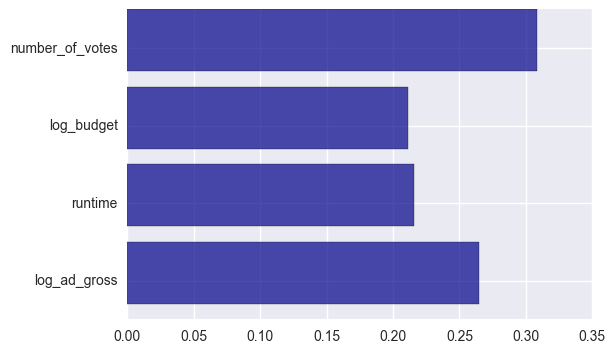

In [29]:
import ml_insights as mli
fig, ax = plt.subplots()
ind = np.array(range(len(X.columns)))+.7
plt.barh(ind,gbmodel1.feature_importances_,color = 'darkblue',alpha =0.7);
ax.set_yticks(ind + .3);
ax.set_yticklabels((X_test.columns))

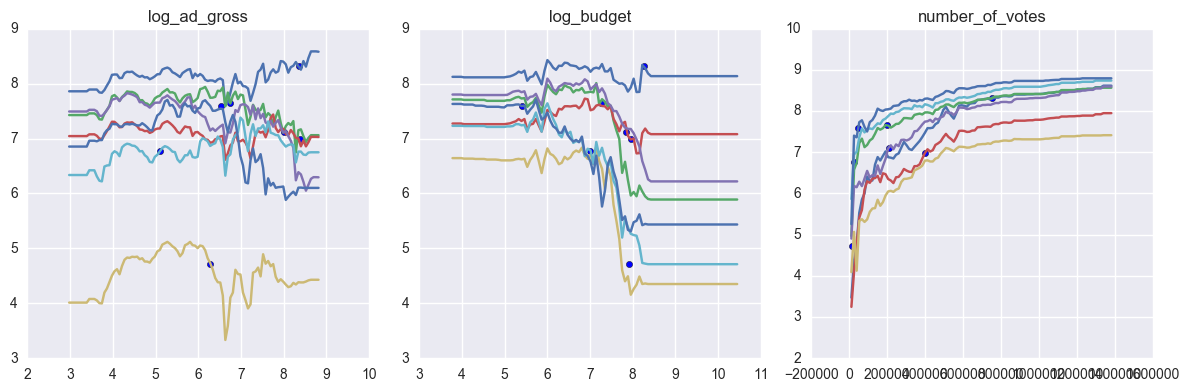

In [30]:
mxr = mli.ModelXRay(gbmodel1,X_test)
indices = mxr.feature_dependence_plots(num_pts=7, figsize = (20,20))

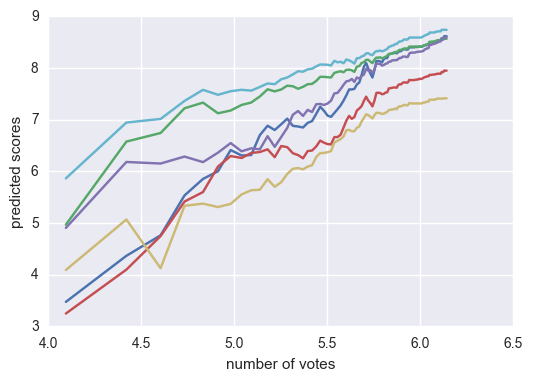

In [31]:
plt.plot(np.log10(mxr.results['number_of_votes'][0]), mxr.results['number_of_votes'][1][indices[0],:])
plt.plot(np.log10(mxr.results['number_of_votes'][0]), mxr.results['number_of_votes'][1][indices[1],:])
plt.plot(np.log10(mxr.results['number_of_votes'][0]), mxr.results['number_of_votes'][1][indices[2],:])
plt.plot(np.log10(mxr.results['number_of_votes'][0]), mxr.results['number_of_votes'][1][indices[3],:])
plt.plot(np.log10(mxr.results['number_of_votes'][0]), mxr.results['number_of_votes'][1][indices[4],:])

plt.plot(np.log10(mxr.results['number_of_votes'][0]), mxr.results['number_of_votes'][1][indices[5],:])

plt.xlabel('number of votes')
plt.ylabel('predicted scores')

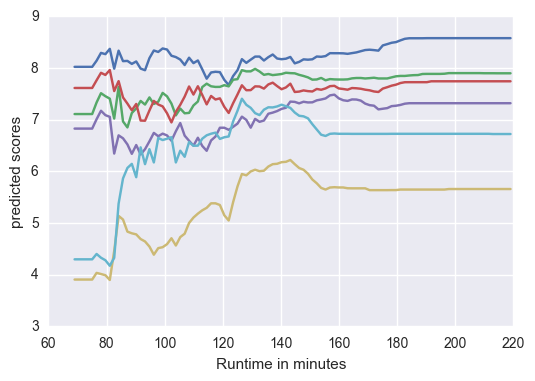

In [32]:
plt.plot(mxr.results['runtime'][0], mxr.results['runtime'][1][indices[0],:])
plt.plot(mxr.results['runtime'][0], mxr.results['runtime'][1][indices[1],:])
plt.plot(mxr.results['runtime'][0], mxr.results['runtime'][1][indices[2],:])
plt.plot(mxr.results['runtime'][0], mxr.results['runtime'][1][indices[3],:])
plt.plot(mxr.results['runtime'][0], mxr.results['runtime'][1][indices[4],:])
plt.plot(mxr.results['runtime'][0], mxr.results['runtime'][1][indices[5],:])

plt.xlabel('Runtime in minutes')
plt.ylabel('predicted scores')

The modelpredicts a slightly higher score for movies with higher runtime but this flattens off over the three hour mark.

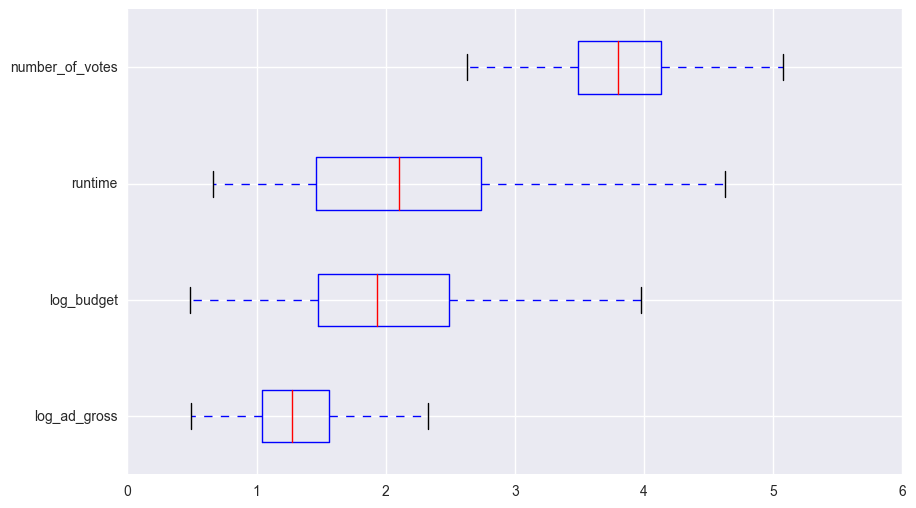

In [33]:
mxr.feature_effect_summary()

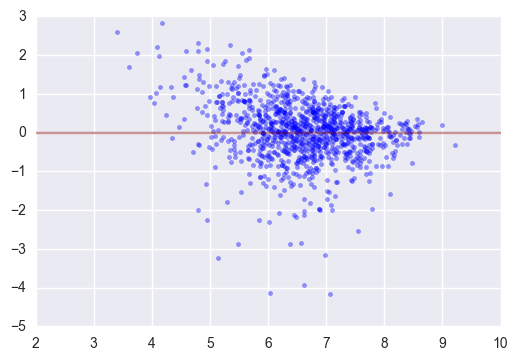

In [34]:
residuals = y_test - gb1_test_pred
plt.plot(gb1_test_pred,residuals,'.',alpha = 0.4,c='b')
plt.plot(np.linspace(2,10,100),np.zeros(100),'maroon',alpha = 0.4)